# Dynamic Phasor Framework - Quick Start

This notebook demonstrates the basic usage of the dynamic phasor simulation framework.

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src')

from dynamic_phasor.core import (
    RLCCircuit, CircuitParameters, create_rim2025_circuit,
    InstantaneousPhasor, PhasorConfig
)

print("Framework loaded!")

04-Framework/notebooks/../src/dynamic_phasor/core/circuit.py:76: SyntaxWarning: invalid escape sequence '\/'
  """


Framework loaded!


## 1. Basic Phasor Transformation

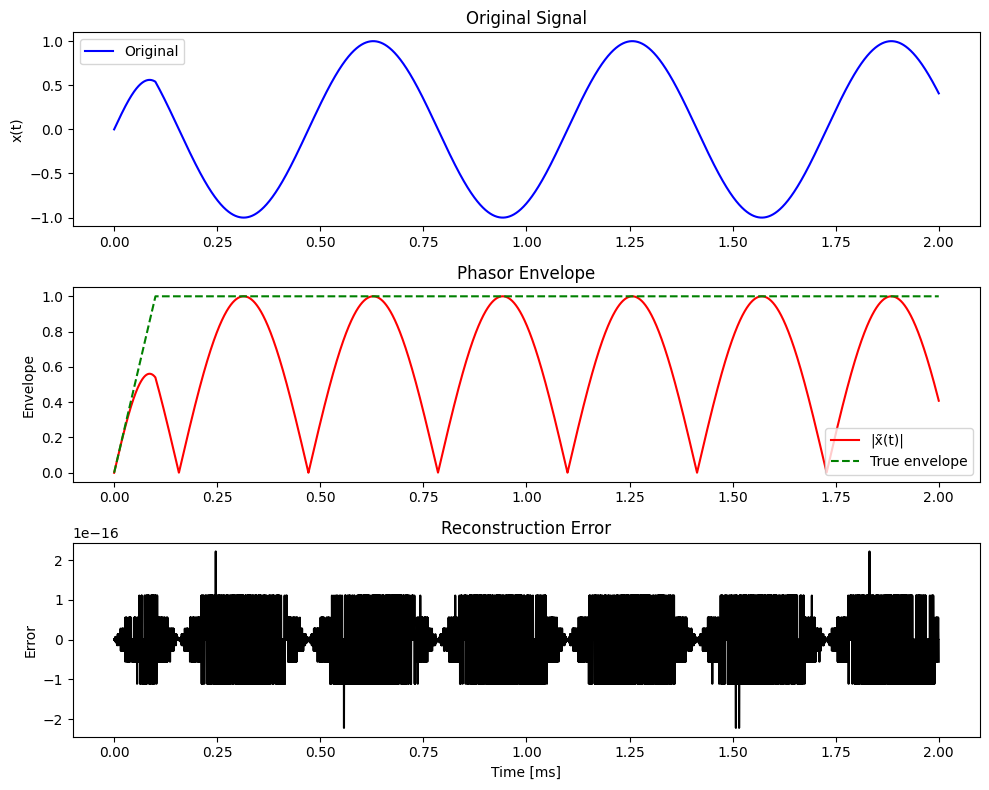

Max reconstruction error: 2.22e-16


In [2]:
# Create a sinusoidal signal with varying envelope
omega = 10e3  # 10 krad/s
t = np.linspace(0, 2e-3, 10000)

# Envelope: ramp up then constant
envelope = np.minimum(t * 1e4, 1.0)
x_real = envelope * np.cos(omega * t)

# Create phasor transform
config = PhasorConfig(omega=omega)
phasor = InstantaneousPhasor(config)

# Transform to phasor
x_phasor = phasor.to_phasor(x_real, t)

# Transform back to real
x_recovered = phasor.to_real(x_phasor, t)

# Plot
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

axes[0].plot(t*1e3, x_real, 'b-', label='Original')
axes[0].set_ylabel('x(t)')
axes[0].set_title('Original Signal')
axes[0].legend()

axes[1].plot(t*1e3, np.abs(x_phasor), 'r-', label='|x̃(t)|')
axes[1].plot(t*1e3, envelope, 'g--', label='True envelope')
axes[1].set_ylabel('Envelope')
axes[1].set_title('Phasor Envelope')
axes[1].legend()

axes[2].plot(t*1e3, x_real - x_recovered, 'k-')
axes[2].set_ylabel('Error')
axes[2].set_xlabel('Time [ms]')
axes[2].set_title('Reconstruction Error')

plt.tight_layout()
plt.show()

print(f"Max reconstruction error: {np.max(np.abs(x_real - x_recovered)):.2e}")

## 2. RLC Circuit Simulation

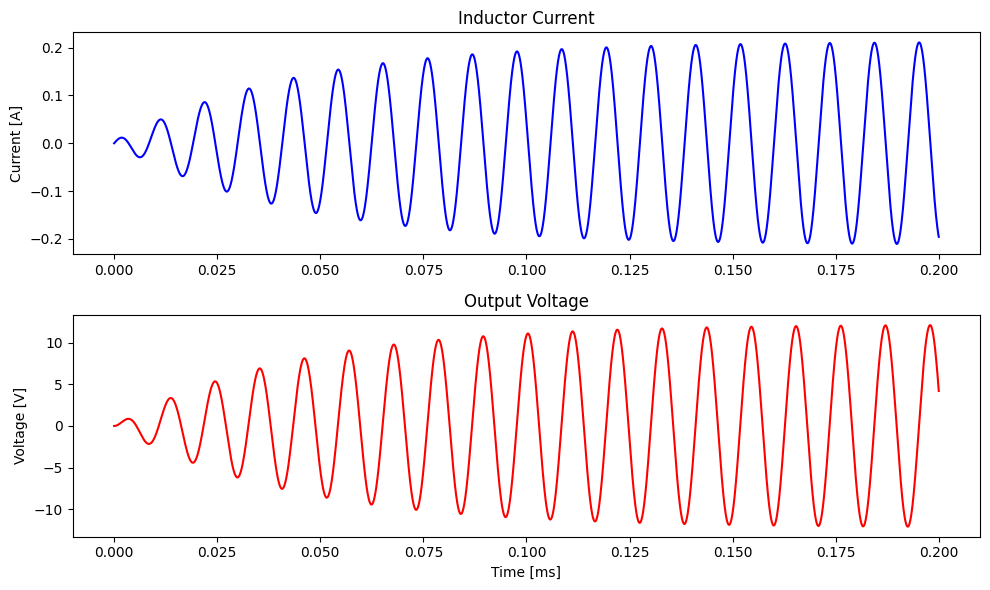

In [3]:
# Create circuit with default (Rim 2025) parameters
circuit = create_rim2025_circuit(omega_s=580e3)

# Define source voltage (step response)
def vs(t):
    if t < 0:
        return 0.0
    return np.cos(580e3 * t)  # Unit amplitude sinusoid

# Solve in time domain
results = circuit.solve_time_domain(vs, t_span=(0, 0.2e-3))

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

t_ms = results['t'] * 1e3

axes[0].plot(t_ms, results['is_t'], 'b-')
axes[0].set_ylabel('Current [A]')
axes[0].set_title('Inductor Current')

axes[1].plot(t_ms, results['vo_t'], 'r-')
axes[1].set_ylabel('Voltage [V]')
axes[1].set_xlabel('Time [ms]')
axes[1].set_title('Output Voltage')

plt.tight_layout()
plt.show()

## 3. Phasor Domain Solution

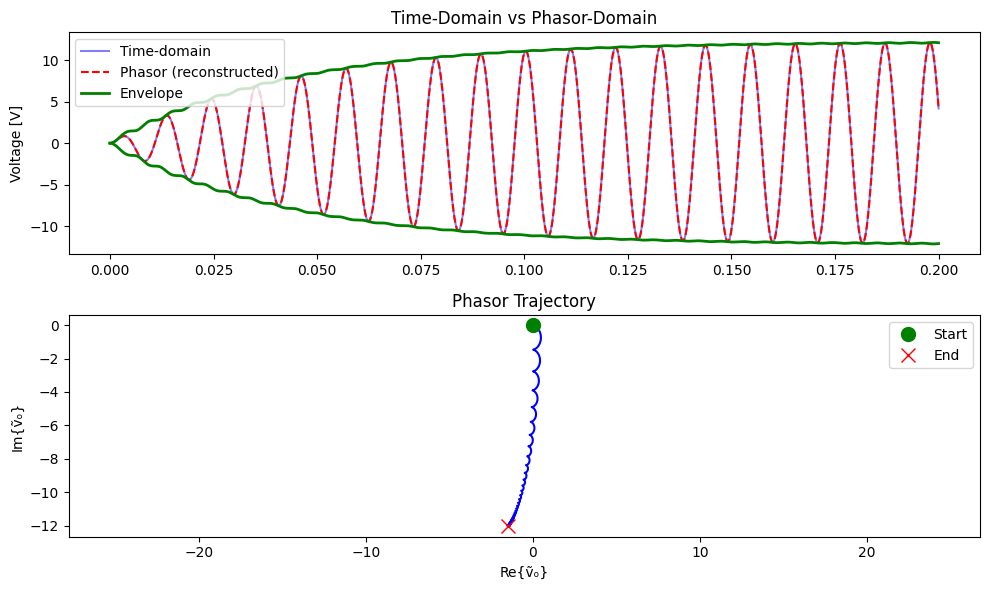

In [4]:
# Phasor source voltage (constant envelope after step)
def vs_phasor(t):
    if t < 0:
        return 0.0 + 0.0j
    return 1.0 + 0.0j  # Unit phasor

# Solve in phasor domain
phasor_results = circuit.solve_phasor_domain(vs_phasor, t_span=(0, 0.2e-3))

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

t_td = results['t'] * 1e3
t_pd = phasor_results['t'] * 1e3

axes[0].plot(t_td, results['vo_t'], 'b-', alpha=0.5, label='Time-domain')
axes[0].plot(t_pd, phasor_results['vo_t'], 'r--', label='Phasor (reconstructed)')
axes[0].plot(t_pd, phasor_results['vo_envelope'], 'g-', linewidth=2, label='Envelope')
axes[0].plot(t_pd, -phasor_results['vo_envelope'], 'g-', linewidth=2)
axes[0].set_ylabel('Voltage [V]')
axes[0].set_title('Time-Domain vs Phasor-Domain')
axes[0].legend()

# Phasor trajectory
axes[1].plot(np.real(phasor_results['vo_phasor']), 
             np.imag(phasor_results['vo_phasor']), 'b-')
axes[1].plot(np.real(phasor_results['vo_phasor'][0]), 
             np.imag(phasor_results['vo_phasor'][0]), 'go', markersize=10, label='Start')
axes[1].plot(np.real(phasor_results['vo_phasor'][-1]), 
             np.imag(phasor_results['vo_phasor'][-1]), 'rx', markersize=10, label='End')
axes[1].set_xlabel('Re{ṽₒ}')
axes[1].set_ylabel('Im{ṽₒ}')
axes[1].set_title('Phasor Trajectory')
axes[1].axis('equal')
axes[1].legend()

plt.tight_layout()
plt.show()

## Next Steps

- Run full validation: `02_rim2025_validation.ipynb`
- Compare methods: `03_method_comparison.ipynb`